<a href="https://colab.research.google.com/github/BelloFaheedah/Big-Data-Analysis/blob/main/Big_Data_Task_Biliqis_Alege.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cycle Hire Usage in London in 2014**

This is a big data problem that will be solved using spark in python (pyspark) on Google Colab. The task in this notebook involves performing a statistical analysis on the cycle hire usage in London in 2014. The research hypothesis is: "In 2014, people ride for longer in autumn than in spring" The provided dataset is on transport for london (Tfl) downloadable from https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip .

In [2]:
#installing pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=297139089ca8bc7efa5477ad8d4e540dd50ac90c5f45e30f1c8c98eb0abb778a
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TflBikeRideDurationAnalys") \
    .getOrCreate()


In [4]:
#downloading and unzipping the dataset
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip


--2023-05-22 06:38:36--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.100.13, 104.16.101.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.100.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   197MB/s    in 1.1s    

2023-05-22 06:38:38 (197 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

In [5]:
# checking out the directory path and the file names in the directory
import os

# Get the current directory path
directory_path = os.getcwd()
print("Directory Path:", directory_path)

# List all the files in the current directory
file_names = os.listdir(directory_path)
print("File Names:", file_names)


Directory Path: /content
File Names: ['.config', '8b Journey Data Extract 01Aug14-16Aug14.csv', '2. Journey Data Extract 03Feb14-01Mar14.csv', '9a Journey Data Extract 17Aug14-31Aug14.csv', '6. Journey Data Extract 25May14-21Jun14.csv', '1. Journey Data Extract 05Jan14-02Feb14.csv', '3. Journey Data Extract 02Mar14-31Mar14.csv', '8a Journey Data Extract 20Jul14-31Jul14.csv', '4. Journey Data Extract 01Apr14-26Apr14.csv', 'cyclehireusagestats-2014.zip', '12b. Journey Data Extract 09Nov14-06Dec14.csv', '12a. Journey Data Extract 09Nov14-06Dec14.csv', '14. Journey Data Extract 08Dec13-04Jan14.csv', '10a. Journey Data Extract 14Sep14-27Sep14.csv', '11b. Journey Data Extract 12Oct14-08Nov14.csv', '7. Journey Data Extract 22Jun14-19Jul14.csv', '11a. Journey Data Extract 12Oct14-08Nov14.csv', '9b Journey Data Extract 01Sep14-13Sep14.csv', '5. Journey Data Extract 27Apr14-24May14.csv', '13a. Journey Data Extract 07Dec14-21Dec14.csv', '10b. Journey Data Extract 28Sep14-11Oct14.csv', '13b. Journ

In [6]:
#merging the dataset and 
from pyspark.sql import SparkSession
from functools import reduce

# Define the directory path where the files are located
directory_path = "/content"  # Change this to the correct directory if needed

# List all the files in the directory
file_names = ["8b Journey Data Extract 01Aug14-16Aug14.csv",
              "2. Journey Data Extract 03Feb14-01Mar14.csv",
              "9a Journey Data Extract 17Aug14-31Aug14.csv",
              "6. Journey Data Extract 25May14-21Jun14.csv",
              "1. Journey Data Extract 05Jan14-02Feb14.csv",
              "3. Journey Data Extract 02Mar14-31Mar14.csv",
              "8a Journey Data Extract 20Jul14-31Jul14.csv",
              "4. Journey Data Extract 01Apr14-26Apr14.csv",
              "cyclehireusagestats-2014.zip",
              "12b. Journey Data Extract 09Nov14-06Dec14.csv",
              "12a. Journey Data Extract 09Nov14-06Dec14.csv",
              "14. Journey Data Extract 08Dec13-04Jan14.csv",
              "10a. Journey Data Extract 14Sep14-27Sep14.csv",
              "11b. Journey Data Extract 12Oct14-08Nov14.csv",
              "7. Journey Data Extract 22Jun14-19Jul14.csv",
              "11a. Journey Data Extract 12Oct14-08Nov14.csv",
              "9b Journey Data Extract 01Sep14-13Sep14.csv",
              "5. Journey Data Extract 27Apr14-24May14.csv",
              "13a. Journey Data Extract 07Dec14-21Dec14.csv",
              "10b. Journey Data Extract 28Sep14-11Oct14.csv",
              "13b. Journey Data Extract 22Dec14-03Jan15.csv",
              "sample_data"]

# Filter the file names based on the keyword
csv_files = [file_name for file_name in file_names if "Journey Data Extract" in file_name]

# Read each file and store them as separate DataFrames
dataframes = []
for file_name in csv_files:
    file_path = f"{directory_path}/{file_name}"
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    # Select only the common columns for merging
    common_columns = ["Rental Id", "Duration", "Bike Id", "End Date", "EndStation Id", "EndStation Name",
                      "Start Date", "StartStation Id", "StartStation Name"]
    df = df.select(*common_columns)
    dataframes.append(df)

# Merge all DataFrames into a single DataFrame
merged_df = reduce(lambda df1, df2: df1.union(df2), dataframes)


In [7]:
#checking out the total number of records in the merged data
merged_df.count()

11481596

In [8]:
#displaying a few of the records
merged_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 35815795|    1860|    939|02/08/2014 15:39|          695|Islington Green, ...|02/08/2014 15:08|              6|Broadcasting Hous...|
| 36165956|     960|   1055|11/08/2014 00:55|           75|Torrens Street, A...|11/08/2014 00:39|            311|Foley Street, Fit...|
| 36371711|    1140|   5202|16/08/2014 17:28|          533|Wellington Row, B...|16/08/2014 17:09|            695|Islington Green, ...|
| 36376079|     480|   7274|16/08/2014 18:17|          140|Finsbury Square ,...|16/08/2014 18:09|            390|Buxton Street 1, ...|
| 36352322|    2100|   1248|16/08/2014 13:26|          

In [9]:
# checking the data types of each column
merged_df.printSchema

<bound method DataFrame.printSchema of DataFrame[Rental Id: int, Duration: int, Bike Id: int, End Date: string, EndStation Id: int, EndStation Name: string, Start Date: string, StartStation Id: int, StartStation Name: string]>

In [10]:
# changing the column "Start Date" to date type (from being a string previously)
from pyspark.sql.functions import to_date, month, when

# Convert the "Start Date" column to DateType
merged_df = merged_df.withColumn("Start Date", to_date("Start Date", "dd/MM/yyyy HH:mm"))


In [11]:
#creating an addititonal column that displays the month number of each start date
# Add a new column "Month" based on the month of the "Start Date" column
merged_df = merged_df.withColumn("Month", month("Start Date"))
merged_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|Month|
+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
| 35815795|    1860|    939|02/08/2014 15:39|          695|Islington Green, ...|2014-08-02|              6|Broadcasting Hous...|    8|
| 36165956|     960|   1055|11/08/2014 00:55|           75|Torrens Street, A...|2014-08-11|            311|Foley Street, Fit...|    8|
| 36371711|    1140|   5202|16/08/2014 17:28|          533|Wellington Row, B...|2014-08-16|            695|Islington Green, ...|    8|
| 36376079|     480|   7274|16/08/2014 18:17|          140|Finsbury Square ,...|2014-08-16|            390|Buxton Street 1, ...|    8|
| 36352322|    2100|   1248|16/08/2014 13:26|          

In [12]:
#creating a new column "Season" that displays the corresponding season based on the start date 

merged_df = merged_df.withColumn("Season",
                                 when(merged_df["Month"].between(3, 5), "Spring")
                                 .when(merged_df["Month"].between(6, 8), "Summer")
                                 .when(merged_df["Month"].between(9, 11), "Autumn")
                                 .otherwise("Winter"))

merged_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|Month|Season|
+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+------+
| 35815795|    1860|    939|02/08/2014 15:39|          695|Islington Green, ...|2014-08-02|              6|Broadcasting Hous...|    8|Summer|
| 36165956|     960|   1055|11/08/2014 00:55|           75|Torrens Street, A...|2014-08-11|            311|Foley Street, Fit...|    8|Summer|
| 36371711|    1140|   5202|16/08/2014 17:28|          533|Wellington Row, B...|2014-08-16|            695|Islington Green, ...|    8|Summer|
| 36376079|     480|   7274|16/08/2014 18:17|          140|Finsbury Square ,...|2014-08-16|            390|Buxton Street 1, ...|    8|Summer|
| 3635

In [13]:
#confirming the unique values in the column season (finding out the different seasons included in the dataset)
merged_df.select("Season").distinct().show()


+------+
|Season|
+------+
|Summer|
|Spring|
|Winter|
|Autumn|
+------+



In [14]:
# Group by the "Season" column and count the number of records in each season
season_counts = merged_df.groupBy("Season").count()

# Display the season counts
season_counts.show()


+------+-------+
|Season|  count|
+------+-------+
|Summer|3244317|
|Spring|2424933|
|Winter|3163998|
|Autumn|2648348|
+------+-------+



In [20]:
#computing the average duration for each season

from pyspark.sql.functions import avg

# Group by the "Season" column and calculate the sum of "duration" for each season
season_duration_avg = merged_df.groupBy("Season").agg(avg("Duration").alias("Average Duration"))

# Display the season duration
season_duration_avg.show()


+------+------------------+
|Season|  Average Duration|
+------+------------------+
|Summer| 1591.169636012757|
|Spring|1515.2960927167885|
|Winter|1349.6579483969172|
|Autumn|1352.4007267927025|
+------+------------------+



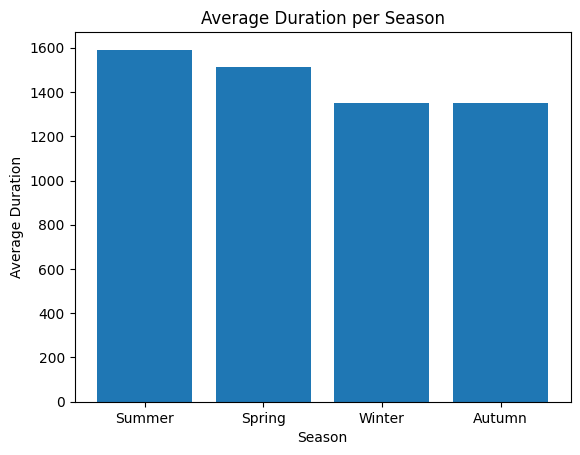

In [21]:
#visualizing the result of the average duration per season
import matplotlib.pyplot as plt

# Convert the season_duration DataFrame to Pandas DataFrame
season_duration_avg_pandas = season_duration_avg.toPandas()

# Plot the bar chart
plt.bar(season_duration_avg_pandas["Season"], season_duration_avg_pandas["Average Duration"])
plt.xlabel("Season")
plt.ylabel("Average Duration")
plt.title("Average Duration per Season")
plt.show()

In [33]:
#computing the total duration for each season
from pyspark.sql.functions import sum


# Group by the "Season" column and calculate the sum of "duration" for each season
season_duration = merged_df.groupBy("Season").agg(sum("Duration").alias("Total Duration"))

# Display the season duration
season_duration.show()

season_duration_pandas = season_duration.toPandas()



+------+--------------+
|Season|Total Duration|
+------+--------------+
|Summer|    5162258700|
|Spring|    3674491500|
|Winter|    2597936340|
|Autumn|    3581627760|
+------+--------------+



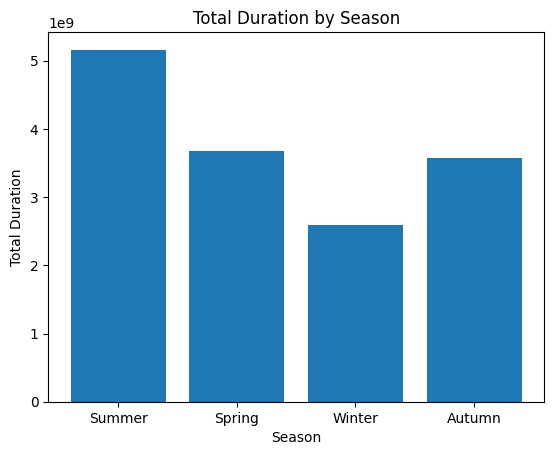

In [54]:
#visualizing the result of the total duration for each season
import matplotlib.pyplot as plt

# Convert the season_duration DataFrame to Pandas DataFrame
season_duration_pandas = season_duration.toPandas()

# Plot the bar chart
plt.bar(season_duration_pandas["Season"], season_duration_pandas["Total Duration"])
plt.xlabel("Season")
plt.ylabel("Total Duration")
plt.title("Total Duration by Season")
plt.show()

In [49]:
autumn_df = merged_df.filter(merged_df.Season == 'Autumn')
autumn_durations = autumn_df.select("Duration").rdd.flatMap(lambda x: x).collect()

spring_df = merged_df.filter(merged_df.Season == 'Spring')
spring_durations = spring_df.select("Duration").rdd.flatMap(lambda x: x).collect()


In [51]:
#calculating the test statistic and p-value
import numpy as np
from scipy.stats import t

# Define the data
#autumn_duration = np.array([1591.169636, 1352.400727])
#spring_duration = np.array([1515.296093])

# Calculate the sample means and standard deviations
mean_autumn = np.mean(autumn_durations)
mean_spring = np.mean(spring_durations)
std_autumn = np.std(autumn_durations, ddof=1)
std_spring = np.std(spring_durations, ddof=1)

# Calculate the sample sizes
n_autumn = len(autumn_durations)
n_spring = len(spring_durations)

# Calculate the degrees of freedom
df = n_autumn + n_spring - 2

# Calculate the standard error of the difference between means
se_diff = np.sqrt((std_autumn**2 / n_autumn) + (std_spring**2 / n_spring))

# Calculate the t-statistic
t_statistic = (mean_autumn - mean_spring) / se_diff

# Calculate the p-value
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))

# Print the t-statistic and p-value
print("t-statistic:", t_statistic)
print("p-value:", p_value)


t-statistic: -14.311998457362165
p-value: 0.0


**Decision criteria:**
If the p-value is less than the significance level where the significance level is 0.05 (p-value < alpha), you reject the null hypothesis. This suggests that the observed data provides sufficient evidence to conclude that the parameter of interest is larger than the null hypothesis value.

*Null hypothesis*: There is equal duration of riders in Autumn as well as Spring

*Alternative hypothesis*: Duration of riders in Autumn is greater than in Spring 

**Decision:** Since the p-value is less than 0.05 (i.e. 0<0.05) is true. The null hypothesis is rejected. 

**Conclusion:** Riders ride for longer duration in autumn than in spring